# Ayuda slides

STOP WARNINGS: http://stackoverflow.com/q/26724378/2268280

Try: `pd.options.mode.chained_assignment = None # default='warn'`

In [1]:
print '''Copy the next code into a first Raw NBconvert Cell to avoid display the commands
<style type="text/css">
.input, .output_prompt {
display:none !important;
}
</style>
'''

Copy the next code into a first Raw NBconvert Cell to avoid display the commands
<style type="text/css">
.input, .output_prompt {
display:none !important;
}
</style>



'b' to hide presentation

Links:
* http://stackoverflow.com/questions/20441848/how-do-i-separate-slides-when-exporting-an-ipython-notebook-to-reveal-js    
* http://www.slideviper.oquanta.info/tutorial/slideshow_tutorial_slides.html#/7  
* https://seqqc.wordpress.com/2015/02/22/make-slides-with-ipython-notebook/
* http://hannes-brt.github.io/blog/2013/08/11/ipython-slideshows-will-change-the-way-you-work/

The commands in the final Cell gives the separation of slides and arrows:

In [2]:
%%bash
#ipython nbconvert Indicadores-articulos.ipynb --to slides --reveal-prefix "http://cdn.jsdelivr.net/reveal.js/2.6.2" 
#cp Indicadores-articulos.slides.html Indicadores-articulos-simple.slides.html
#cp Indicadores-articulos.slides.html /var/www/downloads
#cp Indicadores-articulos-simple.slides.html /var/www/downloads
#git commit -am "Slides update"
#git push origin master

The resulting slides are here:

* http://gfif.udea.edu.co/downloads/Indicadores-articulos.slides.html#/
* http://gfif.udea.edu.co/downloads/Indicadores-articulos-simple.slides.html#/

or

* http://htmlpreview.github.io/?https://raw.githubusercontent.com/restrepo/indicadores/master/Indicadores-articulos.slides.html#/
* http://htmlpreview.github.io/?https://raw.githubusercontent.com/restrepo/indicadores/master/Indicadores-articulos-simple.slides.html#/

#Indicadores Instituto de Física
### Basado  en el [perfil de Google Scholar para el Instituto de Física de la UdeA](https://scholar.google.com/citations?user=mxSOjTYAAAAJ)
### Diego Restrepo


### Advertencia:
El análisis de datos se ha realizado con procesos automáticos propensos a errores de programación.

### Repositorios GitHub:
* http://github.com/restrepo/gssis
* http://github.com/restrepo/indicadores

This notebook can be run directly from  http://mybinder.org/restrepo/indicadores

[![Binder](http://mybinder.org/badge.svg)](http://mybinder.org/repo/restrepo/indicadores/Indicadores-articulos.ipynb)

## Configuraciones generales

In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams.update({'font.size': 15})
#identificadores de Grupo:
s={'GFIF':'g-','GES':'r:','GMC':'c--','GOF':'m-.','MS':'y-','GFAM':'k:','FACOM':'b-'}

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import numpy as np
import datetime
import re
import time

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth',500)
#stop warnings: use with caution!
pd.options.mode.chained_assignment = None  # default='warn'

## Go to load extended DataFrame if updated

In [5]:
def read_google_cvs(gss_url="http://spreadsheets.google.com",\
    gss_format="csv",\
    gss_key="0AuLa_xuSIEvxdERYSGVQWDBTX1NCN19QMXVpb0lhWXc",\
    gss_sheet=0,\
    gss_query="select B,D,E,F,I where (H contains 'GFIF') order by D desc",\
    gss_keep_default_na=False
    ):
    import urllib
    """
    read a google spreadsheet in cvs format and return a pandas DataFrame object.
       ....
       gss_keep_default_na: (False) Blank values are filled with NaN
    """
    issn_url="%s/tq?tqx=out:%s&tq=%s&key=%s&gid=%s" %(gss_url,\
                                           gss_format,\
                                           gss_query,\
                                           gss_key,\
                                           str(gss_sheet))

    gfile=urllib.urlopen(issn_url)
    return pd.read_csv(gfile,keep_default_na=gss_keep_default_na)

def plainstr(stra):
    return stra.replace('á','a').replace('é','e').replace('í','i').\
                replace('ó','o').replace('ú','u').replace('ñ','n')

## Cargue datos
* Formato CSV exportado  del perfil de Google Scholar y extendido con <font color='red'> DOI, Factor de Impacto, Publindex</font> e información de la Universidad de Antioquia: <font color='red'>Autores UdeA, y Grupos</font>, a través del programa en python `csvreader_udea.py` del repositorio http://github.com/restrepo/gssis -> `utilities`
* Tabla de tres columnas: (Datos artículo, <font color='red'>Citaciones</font>, Año) copiada y pegada del perfil de Google Scholar en formato CSV (Desde la hoja de cálculo en Google Drive)
* Información de Estuduiantes de Posgrado:

 `'ESTUDIANTE','ASESOR','Estado','Fecha de ingreso','Fecha de graduación','GRUPO','PROGRAMA'`
 
  (Desde la hoja de cálculo en Google Drive)

Para actualizar use 
  
  `Offline=False`

In [6]:
Offline=False
if not Offline:
    df=pd.read_csv('https://raw.githubusercontent.com/restrepo/gssis/master/utilities/newcitations.csv')
    df.to_csv('newcitations.csv',index=False)
    pc=read_google_cvs(gss_key='1yQXdQdzsX9zBeui52bMcnN-JMt87ofHDjA58kwGJsdI',gss_query="select *")
    pc.to_csv('pd.csv',index=False)
    dfd=read_google_cvs(gss_key="0AuLa_xuSIEvxdERYSGVQWDBTX1NCN19QMXVpb0lhWXc",gss_query="select *",gss_sheet=2)
    dfd['PROGRAMA']='Doctorado'
    dfm=read_google_cvs(gss_key="0AuLa_xuSIEvxdERYSGVQWDBTX1NCN19QMXVpb0lhWXc",gss_query="select *",gss_sheet=1)
    dfm['PROGRAMA']='Maestría'
    dfe=dfd.append(dfm)
    dfe[['ESTUDIANTE','ASESOR','Estado','Fecha de ingreso','Fecha de graduación','GRUPO','PROGRAMA']].to_csv('dfe.csv',index=False)

else:
    df=pd.read_csv('newcitations.csv')
    pc=pd.read_csv('pd.csv')
    pc=pc.fillna('')
    dfe=pd.read_csv('dfe.csv')
    dfe=dfe.fillna('')

http://stackoverflow.com/a/17231361

<h2 id="Articulos">Artículos</h2>
### Metodologia
Desde el perfil de [Google Scholar](https://scholar.google.com/citations?sortby=pubdate&hl=en&user=mxSOjTYAAAAJ&view_op=list_works) para el Instituto, se exportan todos los artículos en formato csv.

Con el programa `csvreader_udea.py` en la carpeta `utilities` del repositorio  de GitHub: [gssis](https://github.com/restrepo/gssis) se añade la siguiente información:  

* El [DOI](http://search.crossref.org), usando el título y el apellido del primer autor de la publicación

* Con del DOI se pueden verificar todos los metadatos. En particular el nombre exacto de la revista. Ejemplo: http://api.crossref.org/works/10.1103/PhysRevD.93.015012

* __Publindex__: Con el nombre exacto de la revista se obtiene la clasificación de Colciencias y su ISSN asociado desde la versión en [google spreadsheet](https://docs.google.com/spreadsheets/d/1umgapW8KOIPqmu_hyjon3n2SXbnbDlmnRnXzjUHcXHE/edit?usp=drive_web) del archivo en excel del Publindex de Colciencias para revistas homologadas. (Se carga el csv desde el código)

* Con el ISSN se obtiene el __factor de impacto__ con: [búsqueda de Google](https://goo.gl/JMHmhS)

* El programa extrae los __autores de la UdeA__ de la lista de autores y asocia al artículo los __Grupos de Investigación__ correspondientes.

En este Notebook de Ipython además se añade la siguiente información
* __Citaciones__: [La página web con el perfil de Google Scholar](https://scholar.google.com/citations?sortby=pubdate&hl=en&user=mxSOjTYAAAAJ&view_op=list_works) muestra hasta 1000 entradas en una tabla de tres columas con la información del artículo, el número de citas y el año de publicación. Si la correspondiente tabla se copia directamente en una hoja cálculo de Google, luego puede ser cargada como un archivo `csv` desde `pandas`. El título del artículo, en la base de datos enriquecida de artículos, puede ser contrastado con la columna de información de la hoja de cáculo de citaciones para asignarle el número de citas correspondiente. De ser necesario se puede recurrir a otra información de artículo como por ejemplo: el volumen de la revista en que fue publicado

* __Área__: A cada artículo se le asigna el área teórica o experimental dependiendo del Grupo al que pertenece, teniendo en cuenta algunos casos especiales para el Grupo de Estado Sólido.


* __Estudiantes__: En la lista de autores de cada artículo se busca si contiene estudiantes de posgrado analizando la fecha del artículo con relación al año de ingreso y de graduación más uno, del estudiante de posgrado localizado.

* Obtenemos los  __artículos publicados__, filtrando  los artículos a los que fue posible asignarles el ISSN o el DOI. Se crea una muestra adcional con las artículos publicados en los últimos cinco años.


El resultado final esta  en el repositorio de GitHub: [restrepo/indicadores](https://github.com/restrepo/gssis/blob/master/utilities/), en el archivo `newcitations_extended.csv`.

##  Preparación de datos

### Compruebe base de datos de artículos
Desde el [repositorio de GitHub](https://github.com/restrepo/gssis/blob/master/utilities/newcitations.csv)

In [7]:
df.columns

Index([u'Year', u'Type', u'Authors', u'Publication', u'Volume', u'Pages',
       u'ISSN', u'Title', u'Impreso', u'PDF', u'Group', u'DOI', u'Type II',
       u'Proyect ID', u'Institution Authors', u'Colciencias Clasification',
       u'Impact Factor', u'Proyecto', u'NPages'],
      dtype='object')

### Arregle manualmente

#### Not UdeA papers

In [8]:
#Already deleted in Google Profile
for i in df[np.logical_and(df['Institution Authors'].str.contains('Romano'),df.Year<2011)].index:
    df.DOI.ix[i]='Not DOI';df.ISSN.ix[i]='0000-0000'

#### Missing UdeA author/

In [9]:
for i in df[df.Title.str.contains('Collider aspects of flavor physics at high Q')].index:
    df.Group.ix[i]='GFIF: Grupo de Fenomenología de Interacciones Fundamentales'
    df['Institution Authors'].ix[i]='Restrepo Quintero Diego Alejandro'
    
for i in df[df.Title.str.contains('The hunt for new physics at the Large Hadron Collider')].index:
    df.Group.ix[i]='GFIF: Grupo de Fenomenología de Interacciones Fundamentales'
    df['Institution Authors'].ix[i]='Restrepo Quintero Diego Alejandro'    

####Artículos con muchos autores
##### CMS collaboration papers

In [10]:
df.Group=df.Group.fillna('Unknown')
jdr=pd.DataFrame()
for issn in ['1126-6708','1550-7998','0370-2693']:
    jdr=jdr.append( df[np.logical_and(df.Group=='Unknown',df.ISSN==issn)] )

for i in jdr.index:
    df.Group[i]='GFIF: Grupo de Fenomenología de Interacciones Fundamentales'
    df['Institution Authors'][i]='José David Ruíz Álvarez'

In [11]:
jdr

,Year,Type,Authors,Publication,Volume,Pages,ISSN,Title,Impreso,PDF,Group,DOI,Type II,Proyect ID,Institution Authors,Colciencias Clasification,Impact Factor,Proyecto,NPages
975,2014,Internacional,"Chatrchyan, Serguei; Khachatryan, V; Sirunyan, AM; Tumasyan, A; Adam, W; Bergauer, T; Dragicevic, M; Erö, J; Fabjan, C; Friedl, M;",Journal of High Energy Physics,2014,1,1126-6708,Measurement of Higgs boson production and properties in the WW decay channel with leptonic final states,NaN,NaN,Unknown,Not DOI,NaN,NaN,NaN,A1,"5,618",NaN,86
976,2014,Internacional,"Chatrchyan, Serguei; Khachatryan, V; Sirunyan, AM; Tumasyan, A; Adam, Wolfgang; Bergauer, T; Dragicevic, M; Erö, J; Fabjan, C; Friedl, M;",Journal of High Energy Physics,2014,1,1126-6708,Search for new physics in events with same-sign dileptons and jets in pp collisions at\ sqrt {s}= 8 TeV,NaN,NaN,Unknown,Not DOI,NaN,NaN,NaN,A1,"5,618",NaN,45
977,2014,Internacional,"Chatrchyan, Serguei; Khachatryan, V; Sirunyan, AM; Tumasyan, A; Adam, W; Bergauer, T; Dragicevic, M; Erö, J; Fabjan, C; Friedl, M;",Physical Review D,89,12003,1550-7998,Search for the standard model Higgs boson produced in association with a W or a Z boson and decaying to bottom quarks,NaN,NaN,Unknown,Not DOI,NaN,NaN,NaN,A1,"4,691",NaN,-1
974,2014,Internacional,CMS collaboration;,Physics Letters B,729,149,0370-2693,Inclusive search for a vector-like T quark with charge in pp collisions at,NaN,NaN,Unknown,Not DOI,NaN,NaN,NaN,A1,"4,569",NaN,23


In [12]:
i=df[df.Publication.str.lower().str.contains('nature')].index[0]
df.Group.ix[i]='GFAM: Grupo de Física Atómica y Molecular'
df['Institution Authors'].ix[i]='Sanz Vicario José Luis'
df['Impact Factor'].ix[i]='41,456'
df['ISSN'].ix[i]='0028-0836'
df['Colciencias Clasification'].ix[i]='A1'

In [13]:
df['Institution Authors']=df['Institution Authors'].fillna('NN')\
.str.replace('Mora Ramos Miguel; ','')

### Primer autor UdeA

In [14]:
for i in df[np.logical_and( df['Institution Authors'].str.contains('Morales Aramburo Álvaro'),\
                           df.Authors.str.contains('Duque, C') )].index:
    df.Group.ix[i]='GMC: Grupo de Materia Condensada'    

In [15]:
for i in df[np.logical_and(df['Institution Authors']=='NN',df.Authors.str.contains('Osorio-Guillén') ) ].index:
    df.Group.ix[i]='GES: Estado Sólido'
    df['Institution Authors'].ix[i]='Osorio Guillén Jorge Mario'
for i in df[np.logical_and(df['Institution Authors']=='NN',df.Authors.str.contains('Mira-Agudelo, A') ) ].index:
    df.Group.ix[i]='GOF: Grupo Óptica y Fotónica'
    df['Institution Authors'].ix[i]='Mira Agudelo Alejandro'
for i in df[np.logical_and(df['Institution Authors']=='NN',df.Authors.str.contains('CMS collaboration') ) ].index:
    df.Group.ix[i]='GFIF: Grupo de Fenomenología de Interacciones Fundamentales'
    df['Institution Authors'].ix[i]='José David Ruíz Álvarez'
for i in df[np.logical_and(df['Institution Authors']=='NN',df.Authors.str.contains('Saavedra, JA') ) ].index:
    df.Group.ix[i]='GFIF: Grupo de Fenomenología de Interacciones Fundamentales'
    df['Institution Authors'].ix[i]='José David Ruíz Álvarez'
for i in df[df['Institution Authors']=='José David Ruíz Alvárez'].index:
    df['Institution Authors'].ix[i]='José David Ruíz Álvarez'
for i in df[np.logical_and(df['Institution Authors']=='NN',df.Authors.str.contains('Longas, R') ) ].index:
    df.Group.ix[i]='GFIF: Grupo de Fenomenología de Interacciones Fundamentales'
    df['Institution Authors'].ix[i]='Longa Robinson'
for i in df[np.logical_and(df['Institution Authors']=='NN',df.Authors.str.contains('Quintero, Diego Alejandro Restrepo') ) ].index:
    df.Group.ix[i]='GFIF: Grupo de Fenomenología de Interacciones Fundamentales'
    df['Institution Authors'].ix[i]='Restrepo Quintero Diego Alejandro'
for i in df[np.logical_and(df['Institution Authors']=='NN',df.Authors.str.contains('Mazo‐Zuluaga, J') ) ].index:
    df.Group.ix[i]=='GES: Estado Sólido'
    df['Institution Authors'].ix[i]= 'Mazo Zuluaga Johan'
for i in df[np.logical_and(df['Institution Authors']=='NN',df.Authors.str.contains('Vera, Carlos A') ) ].index:
    df.Group.ix[i]='GFAM: Grupo de Física Atómica y Molecular'
    df['Institution Authors'].ix[i]='Vera Carlos'
for i in df.fillna('')[np.logical_and(np.logical_and(df['Institution Authors']=='NN',df.Authors.str.contains('Plésiat, E') ), df.Pages>0 )].index:
    df.Group.ix[i]='GFAM: Grupo de Física Atómica y Molecular'
    df['Institution Authors'].ix[i]='Sanz Vicario José Luis'
for i in df[np.logical_and(df['Institution Authors']=='NN',df.Authors.str.contains('Heller, René') ) ].index:
    df.Group.ix[i]='FACOM: Física y Astrofísica Computacional'
    df['Institution Authors'].ix[i]='Zuluaga Callejas Jorge Iván'

In [16]:
df['First_UdeA_Author']=df['Institution Authors'].str.replace(';.*','')

### Compatibilidad con la carpeta de Indicadores en Google Drive

In [17]:
df['Año']=df.Year
df['Tipo']=df.Type
df['Autor(es)']=df.Authors
df['Artículo']=df.Title
df['Vol.']=df.Volume
df['pág.']=df.Pages
df['Revista']=df.Publication
df['Grupo']=df.Group
df['Clasificación Colciencias']=df['Colciencias Clasification']
df['Factor de Impacto']=df['Impact Factor']

### Área

In [18]:
df['Area']='Desconocida'
for G in ['GMC','FACOM','GFAM','MS','GFIF','FN']:
    for i in df[df.Grupo.str.contains(G)].index:
        df.Area.ix[i]='Teórica'

for G in ['GICM','GES','GOF','Biofísica','FIR']:
    for i in df[df.Grupo.str.contains(G)].index:
        df.Area.ix[i]='Experimental'
        
#manual fix
for TGES in ['Morales Aramburo Álvaro','Osorio Guillén Jorge Mario','Reyes Gómez Ernesto Amador']:
    for i in df[df.First_UdeA_Author.str.contains(TGES)].index:
        df.Area.ix[i]='Teórica'        

### Incluyendo citaciones...

To include in official code cvsreader_udea.py

In [19]:
df['Cites']=0
df['Simple']=df.Title.str.replace(r"[^a-zA-Z0-9 ]", " ").str.lower().str.replace('\s+','')
pc['Simple']=pc.Article.str.replace(r"[^a-zA-Z0-9 ]", " ").str.lower().str.replace('\s+','')
for i in range(df.shape[0]):
    mt=pc[pc.Simple.str.match(df.Simple[i])]
    if len(mt)>0:
        if len(mt)>1: #multiple matches. Refine search with, e.g, volume
            mtv=mt[mt.Simple.str.contains(str(df.Volume[i]))]
            if len(mtv)>0:
                mt=mtv
        
        df['Cites'][i]=mt.Cites.replace('*','').replace('','0').astype(int).max()

Citaciones esperadas: 12994 (Feb. 2016). Obtenidas:

In [20]:
df.Cites.sum()

12975

### Estudiantes

##### Artículos con participación de estudiantes

In [21]:
#Todo: 'Año Graduación' :USAR PARA FILTRAR Profesores cuando eran estudiantes
config_inf={'DEBUG':False} #Development mode
config_inf['Years']=range(1995,2016)
#Convertir YYYY-S a YYYY, e.g 2015-1 a 2015
dfe['Año de ingreso']=dfe['Fecha de ingreso'].replace('','0').replace('null','0').str.replace('-1','').str.replace('-2','').astype('int')
dfe['Año de graduación']=dfe['Fecha de graduación'].replace('','0').replace('null','0').str.replace('-1','').str.replace('-2','').astype('int')#.values
#dfe['Año de graduación'].values
#dfei=dfe[dfe['Año de ingreso']>=config_inf['Years'][0]].reset_index(drop=True)
#dfei=dfe[dfe['Año de graduación']>=config_inf['Years'][0]].reset_index(drop=True)
dfei=dfe[dfe.Estado!='Desertor'].reset_index(drop=True)
#Estudiantes
student_coauthor=1 #until 2 years after graduation date
dfd=pd.Series()
art_est=pd.Series()
dfd['D']=dfei[dfei.PROGRAMA=='Doctorado'].reset_index(drop=True)
dfd['M']=dfei[dfei.PROGRAMA=='Maestría'].reset_index(drop=True)
dfd['P']=dfei
for k in dfd.keys():
    art_est[k]=pd.DataFrame()
    if k=='P': est_p=pd.DataFrame()
#phdest=pd.DataFrame()
    dfd[k]['Author']=''
    for i in range(dfd[k].shape[0]):
        est=re.sub('\s+$','',re.sub('^\s+','',dfd[k]['ESTUDIANTE'][i])).replace('  ',' ').split(' ')
        if len(est)==4:
            dfd[k]['Author'][i]='%s, %s' %(plainstr(est[2]),est[0][0])
        elif len(est)==3:        
            dfd[k]['Author'][i]='%s, %s' %(plainstr(est[1]),est[0][0])
        elif len(est)==2:
            dfd[k]['Author'][i]='%s, %s' %(plainstr(est[1]),est[0][0])
        else:
            dfd[k]['Author'][i]='%s, %s' %(plainstr(est[-1]),est[0][0])
        #special cases
        if dfd[k]['Author'][i]=='Duque, C':
            dfd[k]['Author'][i]='Duque, CM'
        if dfd[k]['Author'][i]=='Restrepo, J':
            dfd[k]['Author'][i]='Restrepo Cuartas, J'
    
        ma=df[df['Autor(es)'].str.contains(dfd[k]['Author'][i])]
        if ma.shape[0]>0: #Check also Group
            ma['Estudiante']=dfd[k]['Author'][i]
            ma['Estudiante_full']=dfd[k]['ESTUDIANTE'][i]
            ma['Año Graduación']=dfd[k]['Año de graduación'][i]
            ma=ma[ma['Año']>=dfd[k]['Año de ingreso'][i]]
            if dfd[k]['Fecha de graduación'][i]!='':
                ya=dfd[k]['Año de graduación'][i]+student_coauthor
                #ya=eval(re.sub('-[12]$','',dfd[k]['Fecha de graduación'][i]))+student_coauthor
                ma=ma[ma['Año']<=ya]
    
        art_est[k]=art_est[k].append(ma)

    if k=='P':
        est_p=art_est[k].drop_duplicates()    
    art_est[k]=art_est[k].drop_duplicates().reset_index(True).sort_values('Año',ascending=False).reset_index(drop=True)
    art_est[k]=art_est[k][['Tipo','Artículo','Autor(es)','Año Graduación','Año','Revista','ISSN','Estudiante']]

df['Estudiantes']='Desconocido'
for i in est_p.index:
    lst=sorted(np.unique(est_p['Estudiante_full'][i]))
    sep=''
    if len(lst)>1: sep='; '
    lst=sep.join(lst)
    lst=lst.replace('John Jairo Zuluaga Quintero; Jorge Ivan Zuluaga Callejas','Jorge Ivan Zuluaga Callejas')
    lst=lst.replace('Johan Mazo-Zuluaga; Jorge Ivan Zuluaga Callejas','Jorge Ivan Zuluaga Callejas')
    lst=lst.replace('Johan Mazo-Zuluaga; Juan Pablo Restrepo Cuartas','Johan Mazo-Zuluaga')
    df['Estudiantes'][i]=lst
    #publicadas['Año Graduación'][i]=est_p.sort_values('Año Graduación',ascending=False\
    #                                          )['Año Graduación'][i].reset_index(drop=True)[:-1][0]

# Save Extended Pandas DataFrame

In [22]:
df.to_csv('newcitations_extended.csv',index=False)

# Start from here if not updates

<strong><font color='red'>Don't forget the Initialization cells</font></strong>

In [3]:
start=time.time()

In [4]:
df=pd.read_csv('newcitations_extended.csv')

### Filtramos las publicadas
Las que tienen ISSN o el DOI.

Se muestran algunos resultados...

In [5]:
publicadas=df[~np.logical_and(df['ISSN']=='0000-0000',df['DOI']=='Not DOI')]
publicadas=publicadas.reset_index(drop=True)
publicadas=publicadas.replace('','Desconocido')
publicadas[['Año','Autor(es)','Artículo','Vol.','pág.','ISSN','Revista','Grupo','DOI','Clasificación Colciencias','Factor de Impacto','First_UdeA_Author']][publicadas['DOI']!='Not DOI'][-5:]

,Año,Autor(es),Artículo,Vol.,pág.,ISSN,Revista,Grupo,DOI,Clasificación Colciencias,Factor de Impacto,First_UdeA_Author
947,2015,"Adamo, Angela; Kruijssen, JMD; Bastian, Nate; Silva-Villa, Esteban; Ryon, Jenna;","Probing the role of the galactic environment in the formation of stellar clusters, using M83 as a test bench",452,246,0035-8711,Monthly Notices of the Royal Astronomical Society,FACOM: Física y Astrofísica Computacional,10.1093/mnras/stv1203,A1,"5,521",Silva Villa Esteban
948,2014,"Bastian, N; Adamo, Angela; Schirmer, M; Hollyhead, K; Beletsky, Y; Carraro, G; Davies, B; Gieles, M; Silva-Villa, E;",The effect of spatial resolution on optical and near-IR studies of stellar clusters: implications for the origin of the red excess,444,3829,0035-8711,Monthly Notices of the Royal Astronomical Society,FACOM: Física y Astrofísica Computacional,10.1093/mnras/stu1695,A1,"5,521",Silva Villa Esteban
949,2015,"Niederhofer, Florian; Hilker, Michael; Bastian, Nate; Silva-Villa, Esteban;",No evidence for significant age spreads in young massive LMC clusters,575,62,0004-6361,Astronomy & Astrophysics,FACOM: Física y Astrofísica Computacional,10.1051/0004-6361/201424455,A1,"4,378",Silva Villa Esteban
950,2014,"Ceballos, Jorge A; Giraldo, Marco A; Cossio, Pilar;",Effects of a disulfide bridge prior to amyloid formation of the ABRI peptide,4,36923,0000-0000,RSC Advances,Biofísica,10.1039/C4RA06034B,00,"-1,0",Giraldo Cadavid Marco A.
951,2013,"Restrepo, Diego; Zapata, Oscar; Yaguna, Carlos;",Models with radiative neutrino masses and viable dark matter candidates,2013,1,1126-6708,Journal of High Energy Physics,GFIF: Grupo de Fenomenología de Interacciones Fundamentales,10.1007/JHEP11(2013)011,A1,"5,618",Restrepo Quintero Diego Alejandro


In [6]:
publicadas['Factor de Impacto']=publicadas['Factor de Impacto'].replace('Desconocido',-1)
publicadas['Factor de Impacto']=publicadas['Factor de Impacto'].str.replace(',','.').astype(float)
publicadas['Grupo']=publicadas['Grupo'].fillna('Unknown')

### Publicadas últimos 5 años

Desde 2011

In [7]:
datetime.datetime.now().year-5

2011

In [8]:
publicadas5=publicadas[publicadas['Año']>datetime.datetime.now().year-6]

### Datos a analizar del TOTAL en Google Scholar:

In [9]:
dfp=pd.DataFrame()
dfp.append({'TOTAL':df.shape[0],'Publicadas':publicadas.shape[0],\
            'Publicadas últimos 5 años':publicadas5.shape[0]},ignore_index=True)

,Publicadas,Publicadas últimos 5 años,TOTAL
0,952,348,1037


## Preparando la tabla de datos principal
Similar a la [compartida por correo](https://goo.gl/z9nley) que fue obtenida con conteo manual de artículos.

Número de artículos con estudiantes

In [10]:
autor=pd.Series()
autor['Posgrado']=publicadas[publicadas.Estudiantes!='Desconocido'].groupby('Año').count().Tipo[::-1]
for y in range(df.Year.min(),df.Year.max()):
    if y not in autor.Posgrado.keys():
        autor['Posgrado'][y]=0.

### Contar artículos por año
y clasisificarlos

In [11]:
G=pd.Series()
grupos=['GFIF','GES','GFAM','GMC','GOF','MS','FACOM']
t=publicadas['Año'].value_counts()
i=publicadas[publicadas.Tipo=='Internacional']['Año'].value_counts()
n=publicadas[publicadas.Tipo=='Nacional']['Año'].value_counts()
facom=publicadas[publicadas.Grupo.str.contains('FACOM')]['Año'].value_counts()
for g in grupos:
    G[g]=publicadas[publicadas.Grupo.str.contains(g)]['Año'].value_counts()

## Datos consolidados
Prepare pandas DataFrame

In [12]:
rdf=pd.DataFrame()
ng=pd.Series()
for y in range(1995,2016)[::-1]:
    year=False
    if y in t.keys():
        na=t[y]
    else: na=0
    if y in i.keys():
        ni=i[y]
    else: ni=0
    if y in n.keys():
        nn=n[y]
    else: nn=0
    if y in facom.keys():
        nfacom=facom[y]
    else: nfacom=0
    for g in grupos:
        if y in G[g].keys():
            ng[g]=G[g][y]
    else: nges=0
    
    #FAudea=publicadas[publicadas['Año']==y]['Institution Authors'].fillna('NN')\
    #.str.replace('Mora Ramos Miguel; ','').str.replace(';.*','').unique().shape[0]
    FAudea=publicadas[publicadas['Año']==y]['First_UdeA_Author'].unique().shape[0]
    Audea=np.unique(publicadas[publicadas['Año']==y]['Institution Authors'].fillna('NN').str.split('; ').sum()).shape[0]
    pes=publicadas[publicadas['Año']==y]
    Eudea=np.unique(pes[pes['Estudiantes']!='Desconocido']['Estudiantes'].str.split('; ').sum())
    if Eudea==np.array([0]): #simplify code
        Eudea=0
    else:
        Eudea=Eudea.shape[0]
        #'GES','GOF','GFIF'
    rdf=rdf.append({'year':y,'articles':na,'isi_o_scopus':ni,'nacional':nn,'facom':nfacom,\
                   'GFIF':ng['GFIF'],'GES':ng['GES'],'GFAM':ng['GFAM'],'GMC':ng['GMC'],\
                    'GOF':ng['GOF'],'MS':ng['MS'],'FACOM':ng['FACOM'],\
                    'art_posgrado':autor.Posgrado[y],
                    'first_UdeA_author':FAudea,'UdeA_author':Audea,\
                    'UdeA_estudiante':Eudea},ignore_index=True)

rdf

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


,FACOM,GES,GFAM,GFIF,GMC,GOF,MS,UdeA_author,UdeA_estudiante,art_posgrado,articles,facom,first_UdeA_author,isi_o_scopus,nacional,year
0,6,10,7,9,28,7,2,23,10,20,72,6,21,68,4,2015
1,7,7,12,8,25,4,5,22,10,11,71,7,21,66,5,2014
2,4,19,7,13,14,6,4,27,8,12,70,4,24,62,8,2013
3,1,9,7,8,27,6,6,18,6,8,64,1,17,61,3,2012
4,1,18,7,6,20,6,5,22,6,8,65,1,21,58,7,2011
5,1,15,8,3,12,5,6,20,12,15,51,1,18,45,6,2010
6,2,14,24,12,18,12,7,24,13,22,88,2,21,63,25,2009
7,2,27,10,6,14,2,2,21,14,19,62,2,18,54,8,2008
8,2,12,2,4,21,3,8,15,9,14,49,0,14,39,10,2007
9,1,24,5,8,11,9,10,25,16,26,67,1,22,45,22,2006


# Resultados

## Resultados sobre número de publicaciones

En el plano: número de artículos en función del año. Se añade la información de cuantos primeros autores de la UdeA participan en los artículos

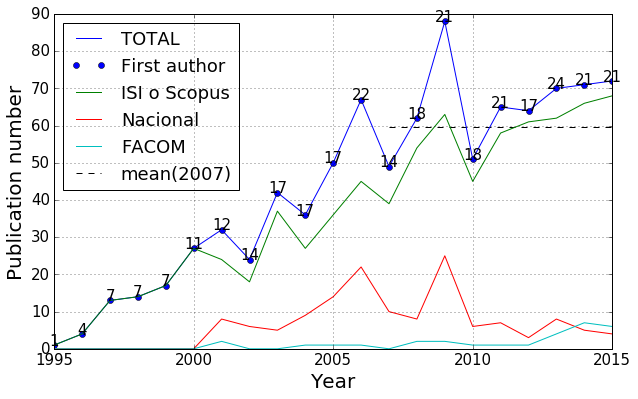

In [13]:
plt.plot(rdf.year,rdf.articles,label='TOTAL')
plt.plot(rdf.year,rdf.articles,'bo',label='First author')
plt.plot(rdf.year,rdf.isi_o_scopus,label='ISI o Scopus')
plt.plot(rdf.year,rdf.nacional,label='Nacional')
plt.plot(rdf.year,rdf.facom,label=u'FACOM')
plt.hlines(rdf[rdf.year>2007].isi_o_scopus.mean(),2007,rdf.year.values[0],linestyles='dashed',label='mean(2007)')
plt.legend(loc='best')
for i in range(len(rdf.year)):
    plt.annotate(str(int(rdf.first_UdeA_author[i])),xy=(rdf.year[i],rdf.articles[i]),\
                 horizontalalignment='center',size=15)
plt.xlabel('Year',size=20)
plt.ylabel('Publication number',size=20)
plt.grid()

En el plano: número de artículos en función del año. Se añade la información del número de autores total de la UdeA que participan en los artículos

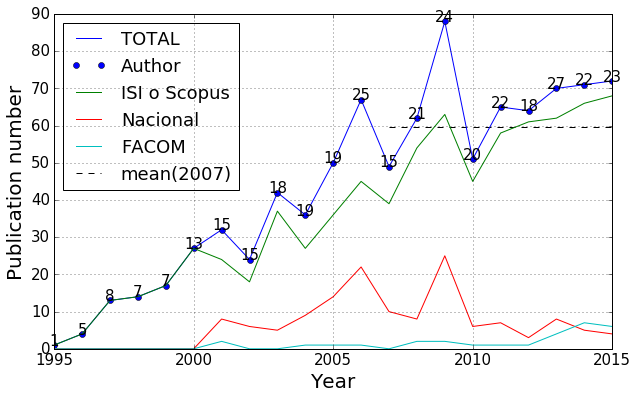

In [14]:
plt.plot(rdf.year,rdf.articles,label='TOTAL')
plt.plot(rdf.year,rdf.articles,'bo',label='Author')
plt.plot(rdf.year,rdf.isi_o_scopus,label='ISI o Scopus')
plt.plot(rdf.year,rdf.nacional,label='Nacional')
plt.plot(rdf.year,rdf.facom,label=u'FACOM')
plt.hlines(rdf[rdf.year>2007].isi_o_scopus.mean(),2007,rdf.year.values[0],linestyles='dashed',label='mean(2007)')
plt.legend(loc='best')
for i in range(len(rdf.year)):
    plt.annotate(str(int(rdf.UdeA_author[i])),xy=(rdf.year[i],rdf.articles[i]),\
                 horizontalalignment='center',size=15)
plt.xlabel('Year',size=20)
plt.ylabel('Publication number',size=20)
plt.grid()

El programa no está muy optimizado para encontar TODOS los autores UdeA

En los picos hay una mezcla de profesores y estudiantes...

We can see an oscillating behaviour between 2000 until 2010 with peaks at 2001, 2003, 2006, and 2009. The peaks show some correlation both the international and national publications, and as I will see later, several research groups. We already know that there was a decline of interest in theCongreso Nacional de Fisica after 2009.

#### Congreso nacional de Física 
* XVI Congreso nacional de Física realizado en la ciudad de Cali del 26
al 30 de junio de 1995. 
* XVII Congreso nacional de Física realizado en la ciudad de Medellín
del 23-27 de junio de 1997.
* XVIII Congreso nacional de Física realizado en la ciudad de Bogotá del
28 de junio al 2 de julio de 1999.
* XIX Congreso nacional de Física realizado en la ciudad de Manizalez
del 24 al 2 de septiembre de 2001. 
* XX Congreso nacional de Física realizado en la ciudad de Armenia del
1 al 5 de septiembre de 2003. 
* XXI Congreso Nacional de Física: Universidad del Atlántico, Barranquilla, Octubre 24-28 de 2005
* XXII Congreso Nacional de Física, 
Ibague, Tolima, Octubre 22 al 26 de 2007
* XXIII Congreso Nacional de Física
Santa Marta, Octubre 5 al 9 de 2009
* XXIV CONGRESO NACIONAL DE FÍSICA
Hotel Tequendama, 3 al 7 de Octubre de 2011, BOGOTÁ D.C.
* XXV Congreso Nacional de Física
Armenia - Quindío, 25 al 29 de agosto de 2013, Armenia
* XXVI Congreso Nacional de Física 
Manizales del 29 de septiembre al 2 de octubre. 
http://www.xxvi-cnf.co

#### Escuela de materia condesanda

* VII Escuela Nacional de Física de la Materia Condensada
Tunja - Boyacá - Colombia, Octubre 23-27, 2006
* VIII Escuela Nacional de Física de la Materia Condensada
Pereira, septiembre 22 al 26 de 2008
* La IX ESCUELA NACIONAL DE FÍSICA DE LA MATERIA CONDENSADA (IX ENFMC).
Ibagué, los días 6, 7 y 8 de octubre de 2010.
* La X Escuela Nacional de Física de la Materia Condensada (ENFMC-2012)
Universidad Nacional de Colombia Sede Manizales del 10 al 12 de Octubre de 2012,

#### Others

Latin American Conference on the Applications of the Mössbauer Effect, (LACAME 2012) held in Medellin, Colombia, November 11 - 16, 2012


The hypthothesis is that the dealine implied by the Congreso, trigger the production of first 

2009 Team

In [15]:
y=2009
values=np.unique(publicadas[publicadas['Año']==y]['Institution Authors'].fillna('NN').str.split('; ').sum())
pd.Series(dict(zip(range(values.shape[0]), values)))

0                Arnache Olmos Óscar L.
1            Barrera Ramírez John Fredy
2              Barrero Meneses César A.
3                Carlos Duque Echeverri
4                          Girata Doris
5                   Henao Henao Rodrigo
6            Jaramillo Arango Daniel E.
7                Mahecha Gómez Jorge E.
8                    Mazo Zuluaga Johan
9                Mira Agudelo Alejandro
10              Morales Aramburo Álvaro
11                         Nardi Enrico
12           Osorio Guillén Jorge Mario
13                   Osorio Vélez Jaime
14      Ponce Gutiérrez William Alberto
15                          Páez Manuel
16             Restrepo Cárdenas Johans
17    Restrepo Quintero Diego Alejandro
18           Reyes Gómez Ernesto Amador
19          Rodríguez Rey Boris Anghelo
20            Rueda Muñoz Edgar Alberto
21               Sanz Vicario José Luis
22                  Zapata Noreña Oscar
23          Zuluaga Callejas Jorge Iván
dtype: object

2013 Team

In [16]:
y=2013
values=np.unique(publicadas[publicadas['Año']==y]['Institution Authors'].fillna('NN').str.split('; ').sum())
pd.Series(dict(zip(range(values.shape[0]), values)))

0                Arnache Olmos Óscar L.
1            Barrera Ramírez John Fredy
2              Barrero Meneses César A.
3                Carlos Duque Echeverri
4               Cuartas Restrepo Pablo 
5             Ferrín Vázquez Ignacio R.
6                   Henao Henao Rodrigo
7               José David Ruíz Álvarez
8                    Mazo Zuluaga Johan
9                Mira Agudelo Alejandro
10              Morales Aramburo Álvaro
11                                   NN
12                         Nardi Enrico
13           Osorio Guillén Jorge Mario
14                   Osorio Vélez Jaime
15            Pachón Contreras Leonardo
16      Ponce Gutiérrez William Alberto
17                          Páez Manuel
18             Restrepo Cárdenas Johans
19    Restrepo Quintero Diego Alejandro
20           Reyes Gómez Ernesto Amador
21          Rodríguez Rey Boris Anghelo
22                  Romano Antonio Enea
23            Rueda Muñoz Edgar Alberto
24               Sanz Vicario José Luis


O en términos del número de estudiantes de posgrado en la lista de autores 

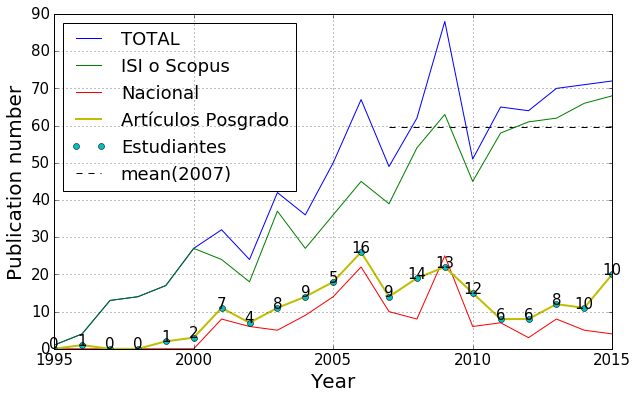

In [17]:
plt.plot(rdf.year,rdf.articles,label='TOTAL')
plt.plot(rdf.year,rdf.isi_o_scopus,label='ISI o Scopus')
plt.plot(rdf.year,rdf.nacional,label='Nacional')
plt.plot(rdf.year,rdf.art_posgrado,'y-',lw=2,label=u'Artículos Posgrado')
plt.plot(rdf.year,rdf.art_posgrado,'co',lw=2,label='Estudiantes')
plt.hlines(rdf[rdf.year>2007].isi_o_scopus.mean(),2007,rdf.year.values[0],linestyles='dashed',label='mean(2007)')
plt.legend(loc='best')
for i in range(len(rdf.year)):
    plt.annotate(str(int(rdf.UdeA_estudiante[i])),xy=(rdf.year[i],rdf.art_posgrado[i]),\
                 horizontalalignment='center',size=15)
plt.xlabel('Year',size=20)
plt.ylabel('Publication number',size=20)
plt.grid()

2009 Student's Team

In [18]:
y=2009
values=np.unique(publicadas[np.logical_and(publicadas.Year==y,publicadas.Estudiantes!='')].Estudiantes.str.split('; ').sum())
pd.Series(dict(zip(range(values.shape[0]), values)))

0               Ana Maria Calle Arcila
1          Carlos A. Vargas Castrillón
2              Carlos Andrés Vera Ciro
3                          Desconocido
4            Edgar Alberto Rueda Muñoz
5      Francisco Eugenio López Giraldo
6            Guillermo Miranda Pedraza
7     Jeaneth Patricia Urquijo Morales
8                   Johan Mazo-Zuluaga
9     Johana Alexandra Herrera Ruales 
10         Oscar Alberto Zapata Noreña
11        Ricardo León Restrepo Arango
12       Richard H. Benavides Palacios
13              Yithsbey Giraldo Usuga
dtype: object

#### Observación
En los picos se nota un incremento en la participación de estudiantes, sobre todo en revistas nacionales (¿Congresos?)

Miremos entonces los Grupos

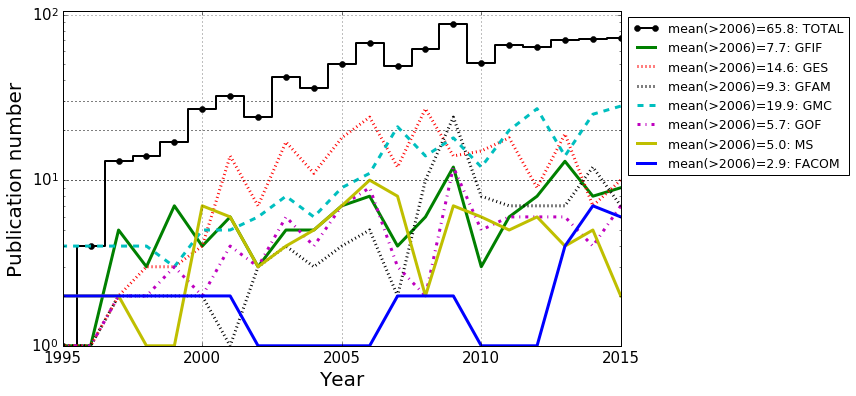

In [19]:
#http://stackoverflow.com/a/15191183/2268280
plt.step(rdf.year,rdf.articles,'ko',lw=2,label='mean(>2006)=%.1F: TOTAL'  %rdf[rdf.year>2006].articles.mean(), where='mid')
GT=np.zeros(21)
plt.xscale('linear')
plt.yscale('log')
for g in grupos:
    GT=GT+rdf[g]
    #drawstyle='steps-mid',
    plt.plot(rdf.year,rdf[g],s[g],lw=3,label=u'mean(>2006)=%.1F: %s'  %( rdf[rdf.year>2006][g].mean(),g ) )    
    #plt.semilogy(rdf.year,rdf[g],'k.',lw=2)    
    
#plt.semilogy(rdf.year,GT ,label='Suma')    #crosscheck
plt.hlines(10,1995,2015,linestyles=':')
plt.hlines(20,1995,2015,linestyles=':')
plt.hlines(30,1995,2015,linestyles=':')
plt.ylim(1,105)
plt.legend(bbox_to_anchor=(1.42, 1),loc='upper right',fontsize='small')
plt.xlabel('Year',size=20)
plt.ylabel('Publication number',size=20)
plt.grid()

## Resultados Por Grupos de Investigación

#### Histórico

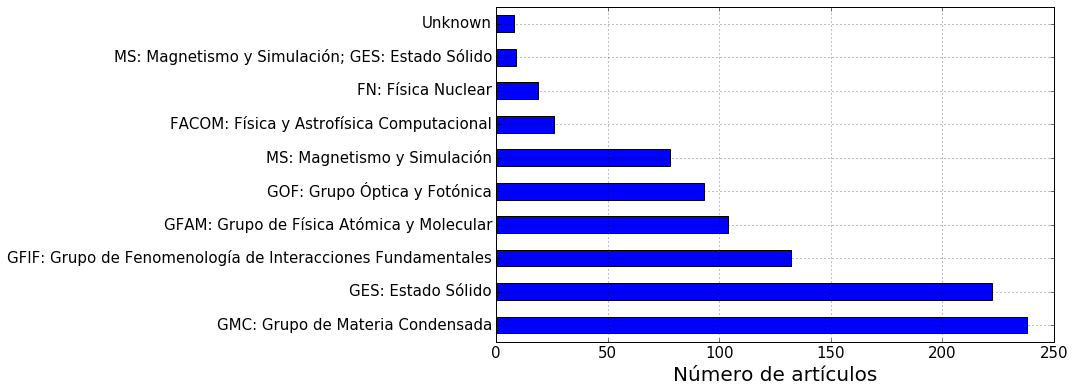

In [20]:
publicadas['Grupo'].value_counts()[:10].plot(kind='barh', rot=0, grid=True)
plt.xlabel(u'Número de artículos',size=20)

#### Últimos cinco años


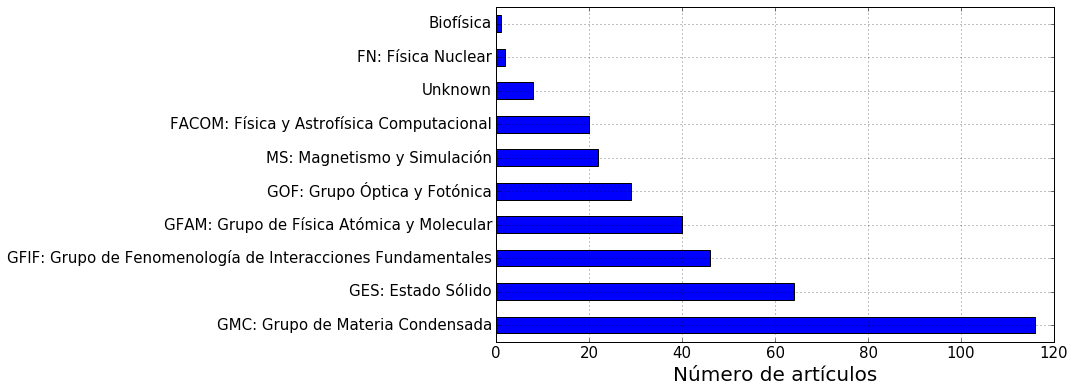

In [21]:
publicadas5['Grupo'].value_counts()[:10].plot(kind='barh', rot=0,grid=True)
plt.xlabel(u'Número de artículos',size=20)

### Conclusión
Se ha alcanzado un valor asintótico, no solo en el número total, sino también en general en los grupos

H0 lo separó en H 0 y no lo encontró: solución: admita alguna palabras faltantes en títulos largos:

* http://dx.doi.org/10.1209/0295-5075/109/39002 

## Resultados por  Áreas

#### Histórico

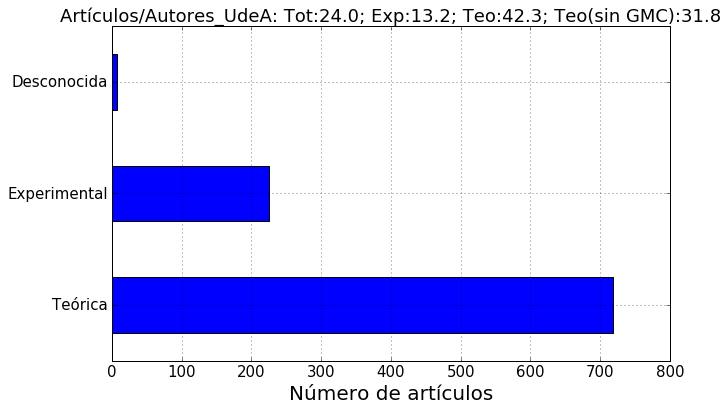

In [22]:
Tot=publicadas.shape[0]/np.unique(publicadas['Institution Authors'].fillna('NN').str.split('; ').sum()).shape[0]
p=publicadas['Area'].value_counts()
at=np.unique(publicadas[publicadas.Area=='Teórica']['Institution Authors'].fillna('NN').str.split('; ').sum()).shape[0]
ae=np.unique(publicadas[publicadas.Area=='Experimental']['Institution Authors'].fillna('NN').str.split('; ').sum()).shape[0]
gmc=publicadas[publicadas.Grupo.str.contains('GMC')].shape[0]
publicadas['Area'].value_counts().plot(kind='barh', rot=0, grid=True)
plt.title(u'Artículos/Autores_UdeA: Tot:%0.1f; Exp:%0.1f; Teo:%0.1f; Teo(sin GMC):%0.1f' %(Tot, p.Experimental/float(ae),p['Teórica']/float(ae),\
                                                               (p['Teórica']-gmc)/float(ae-2) ) )
plt.xlabel(u'Número de artículos',size=20)

#### Últimos 5 años:

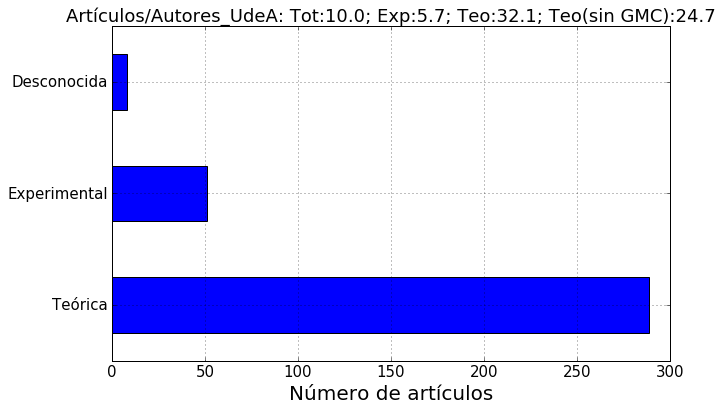

In [23]:
Tot=publicadas5.shape[0]/np.unique(publicadas5['Institution Authors'].fillna('NN').str.split('; ').sum()).shape[0]
p=publicadas5['Area'].value_counts()
at=np.unique(publicadas5[publicadas5.Area=='Teórica']['Institution Authors'].fillna('NN').str.split('; ').sum()).shape[0]
ae=np.unique(publicadas5[publicadas5.Area=='Experimental']['Institution Authors'].fillna('NN').str.split('; ').sum()).shape[0]
gmc=publicadas5[publicadas5.Grupo.str.contains('GMC')].shape[0]
publicadas5['Area'].value_counts().plot(kind='barh', rot=0, grid=True)
plt.title(u'Artículos/Autores_UdeA: Tot:%0.1f; Exp:%0.1f; Teo:%0.1f; Teo(sin GMC):%0.1f' %(Tot, p.Experimental/float(ae),p['Teórica']/float(ae),\
                                                               (p['Teórica']-gmc)/float(ae-2) ) )
plt.xlabel(u'Número de artículos',size=20)

In [24]:
pd.DataFrame().append(\
  {'Artículos por autor por año':'%0.1f' %(Tot/5),\
  'Experimental':'%0.1f' %(p.Experimental/float(ae)/5),\
  'Teórica':'%0.1f' %(p['Teórica']/float(ae)/5),\
  'Teórica sin GMC':'%0.1f' %( (p['Teórica']-publicadas5[publicadas5.Grupo.str.contains('GMC')].shape[0]\
                               )/float(ae)/5)},ignore_index=True)
#(Tot, p.Experimental/float(ae),p['Teórica']/float(ae), (p['Teórica']-gmc)/float(ae-2) )

,Artículos por autor por año,Experimental,Teórica,Teórica sin GMC
0,2.0,1.1,6.4,3.8


#### Conclusión
En teoría se produce más

## Resultados de autores UdeA
Primeros 15 y sólo durante su afiliación a la UdeA

In [25]:
publifull=pd.DataFrame()
publifull=publifull.append(publicadas)
publifull['UdeA_Author']=publicadas.First_UdeA_Author
for  i in publicadas.index:
    alist=publicadas.ix[i]['Institution Authors'].split('; ')
    if len(alist)>1:
        for a in alist[1:]:
            publifull=publifull.append(publicadas.ix[i],ignore_index=True)
            publifull['UdeA_Author'].ix[publifull[-1:].index[0]]=a        
            
publifull5=publifull[publifull['Año']>datetime.datetime.now().year-6]

####  Histórico

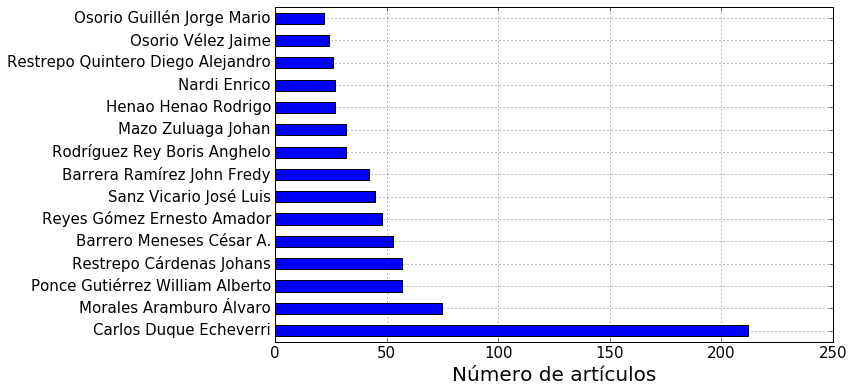

In [26]:
publicadas['First_UdeA_Author'].value_counts()[:15].plot(kind='barh', rot=0, grid=True)
plt.xlabel(u'Número de artículos',size=20)

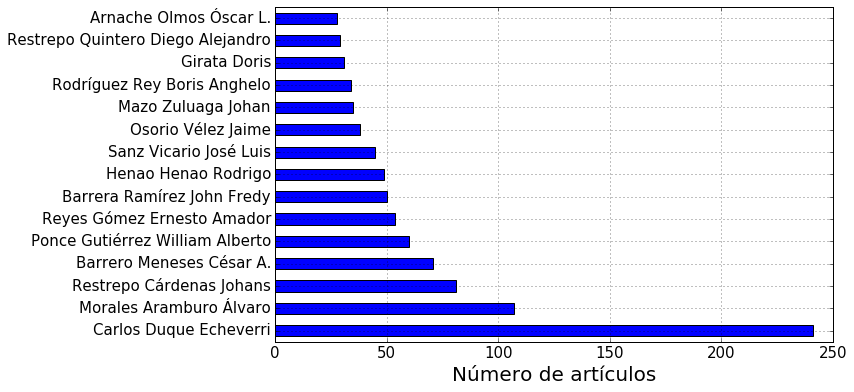

In [27]:
publifull['UdeA_Author'].value_counts()[:15].plot(kind='barh', rot=0, grid=True)
plt.xlabel(u'Número de artículos',size=20)

#### Últimos cinco años

(1, 109)

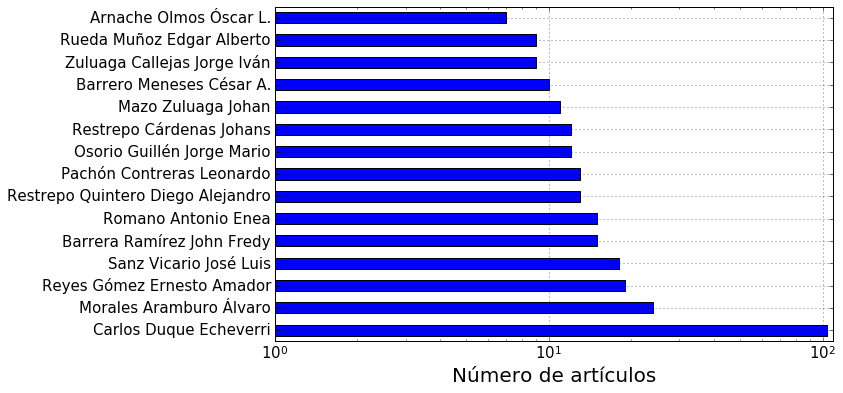

In [28]:
publicadas5['First_UdeA_Author'].value_counts()[:15].plot(kind='barh', rot=0, grid=True)#
plt.xlabel(u'Número de artículos',size=20)
plt.xscale('log')
plt.xlim(1,publicadas5['First_UdeA_Author'].value_counts().max()+5)

(1, 121)

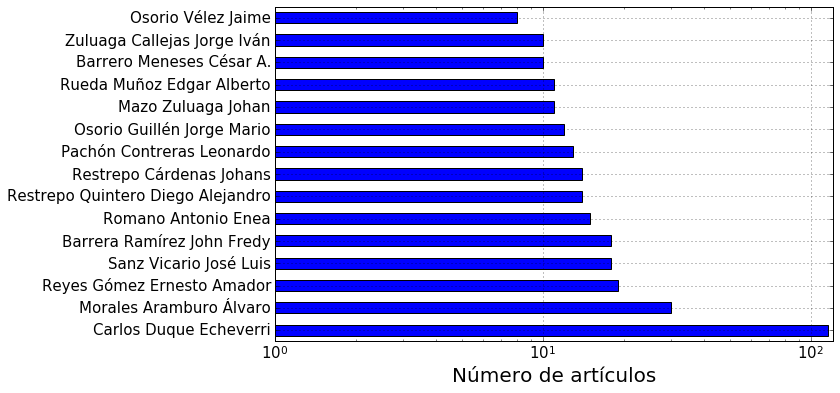

In [29]:
publifull5['UdeA_Author'].value_counts()[:15].plot(kind='barh', rot=0, grid=True)
plt.xlabel(u'Número de artículos',size=20)
plt.xscale('log')
plt.xlim(1,publifull5['UdeA_Author'].value_counts().max()+5)

###Conclusión
Se alcanza a notar algo del relevo generacional

Ejemplos plots con `pandas`: http://pandas.pydata.org/pandas-docs/dev/visualization.html

### Internacionales y Nacionales

The group counts, analogous to the value_counts function above, can be computed
    using size. This result is then reshaped into a table with unstack:

#### Histórico

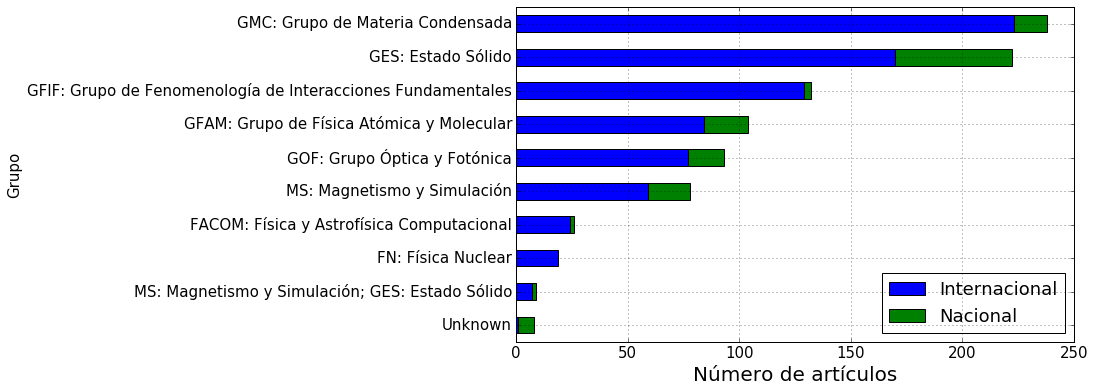

In [30]:
tipo = np.where(publicadas['Tipo'].str.contains('Internacional'),'Internacional', 'Nacional')
by_group_tipo = publicadas.groupby(['Grupo', tipo])
gt_counts = by_group_tipo.size().unstack().fillna(0)
indexer = gt_counts.sum(1).argsort()
count_subset = gt_counts.take(indexer)
count_subset[15:].plot(kind='barh', stacked=True,grid=True)
plt.xlabel(u'Número de artículos',size=20)

#### Últimos 5 años

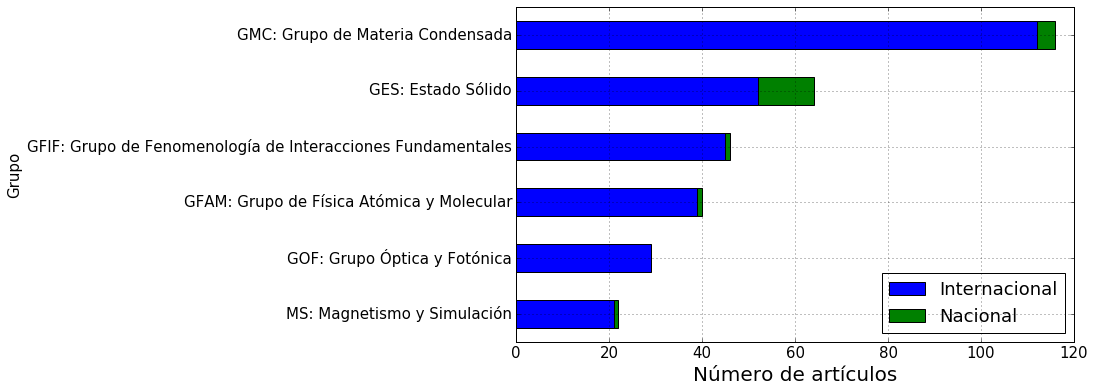

In [31]:
tipo5 = np.where(publicadas5['Tipo'].str.contains('Internacional'),'Internacional', 'Nacional')
by_group_tipo5 = publicadas5.groupby(['Grupo', tipo5])
gt_counts = by_group_tipo5.size().unstack().fillna(0)
indexer = gt_counts.sum(1).argsort()
count_subset = gt_counts.take(indexer)
count_subset[4:].plot(kind='barh', stacked=True,grid=True)
plt.xlabel(u'Número de artículos',size=20)

## Resultados por citaciones a los artículos

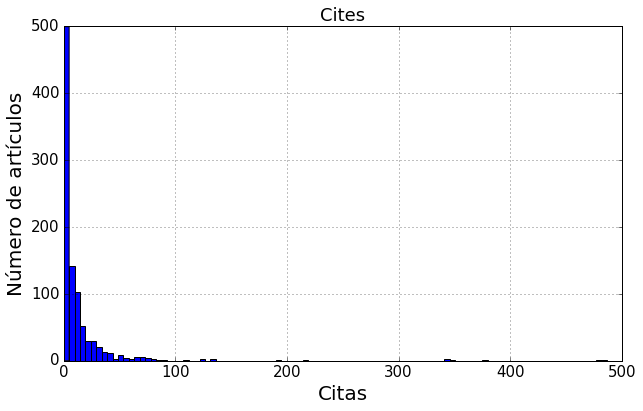

In [32]:
publicadas[['Cites']].hist(bins=100)
#plt.ylabel(u'Número de artículos',size=20)
plt.xlabel(u'Citas',size=20)
plt.ylabel(u'Número de artículos',size=20)

(1.0, 100)

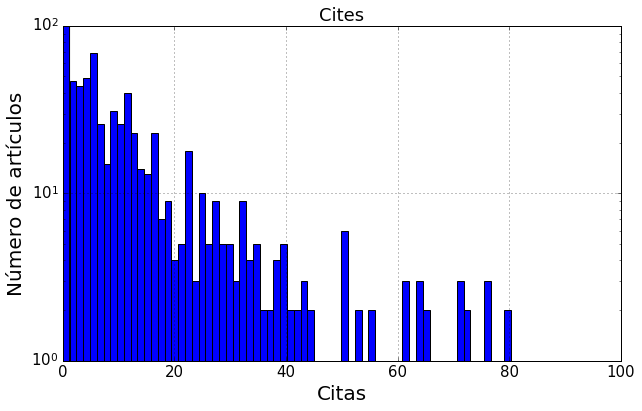

In [33]:
publicadas[['Cites']].hist(bins=400)
#plt.ylabel(u'Número de artículos',size=20)
plt.xlabel(u'Citas',size=20)
plt.ylabel(u'Número de artículos',size=20)
plt.yscale('log')
plt.yscale('log')
plt.xlim(0,100)
plt.ylim(0,100)

#### Global
Incluye el índice h [https://en.wikipedia.org/wiki/H-index]: 
h publicaciones tienen al menos h Citas

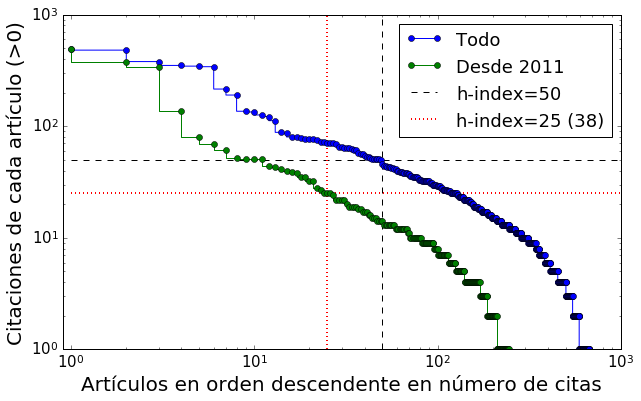

In [34]:
def h_index(x,y):
    '''h-index as in https://en.wikipedia.org/wiki/H-index
    {1:10,2:8,3:5,4:4,5:3} -> 4
    {1:25,2:8,3:5,4:3,5:3} -> 3
    '''
    ax=np.asarray(x)
    ay=np.asarray(y)
    if np.abs(ax-ay).min()<=2:
        h=ay[np.abs(ax-ay)==np.abs(ax-ay).min()]
    else: #od the difference is large, depart from wikipedia and take conservative value
        h=ax[np.abs(ax-ay)==np.abs(ax-ay).min()]
    if h.shape[0]!=0:
        return h[0]
    else:
        return -1
    
y=publicadas.sort_values(by='Cites',ascending=False).reset_index(drop=True).Cites
x=np.asarray(y.index+1)
h=h_index(x,y)
plt.hlines(h,1,1000,linestyles='dashed',label='h-index=%d' %h)
plt.vlines(h,1,1000,linestyles='dashed')
plt.step(x,y,'bo',lw=1,label='Todo')

y=publicadas5.sort_values(by='Cites',ascending=False).reset_index(drop=True).Cites
x=np.asarray(y.index+1)
h=h_index(x,y)
plt.hlines(h,1,1000,linestyles='dotted',lw=2,colors='r',label='h-index=%d (38)' %h)
plt.vlines(h,1,1000,linestyles='dotted',lw=2,colors='r')
plt.step(x,y,'go',lw=1,label='Desde %d' %publicadas5.Year.min())
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')

plt.xlim(1-0.1)
plt.legend(loc='best')
plt.xlabel(u'Artículos en orden descendente en número de citas',size=20)
plt.ylabel(u'Citaciones de cada artículo (>0)',size=20)

En perfil en Google Scholar:  de TODAS las publicaciones,
<font color='red'>38 publicaciones</font> han alcanzado 38 citas en los últimos cinco años

In [35]:
publicadas.sort_values(by='Cites',ascending=False).reset_index(drop=True)[:10][\
                    ['Year','Publication','First_UdeA_Author','Cites']]

,Year,Publication,First_UdeA_Author,Cites
0,2014,Journal of High Energy Physics,José David Ruíz Álvarez,487
1,2008,Physics Reports,Nardi Enrico,480
2,2014,Journal of High Energy Physics,José David Ruíz Álvarez,379
3,2010,Nature,Sanz Vicario José Luis,350
4,2006,Journal of High Energy Physics,Nardi Enrico,345
5,2014,Physical Review D,José David Ruíz Álvarez,341
6,1980,Physical Review D,Ponce Gutiérrez William Alberto,215
7,2009,Journal of Cosmology and Astroparticle Physics,Nardi Enrico,190
8,2014,Physics Letters B,José David Ruíz Álvarez,136
9,2004,Physical Review B,Morales Aramburo Álvaro,134


La diferencia con los últimos cinco años puede ser atribuible a los artículos con muchos autores

#### Por Grupos histórico

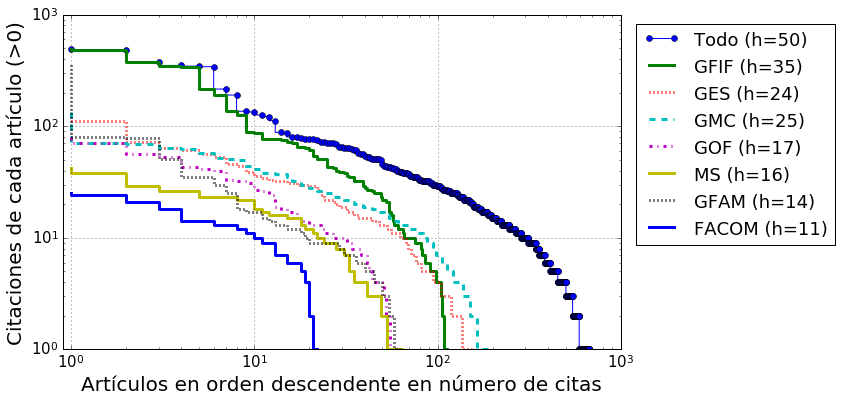

In [36]:
y=publicadas.sort_values(by='Cites',ascending=False).reset_index(drop=True).Cites
x=np.asarray(y.index+1)
plt.step(x,y,'bo',lw=1,label='Todo (h=%d)' %h_index(x,y))
plt.xscale('log')
plt.yscale('log')


for G in ['GFIF','GES','GMC','GOF','MS','GFAM','FACOM']:
    y=publicadas[publicadas.Grupo.str.contains(G)].sort_values(by='Cites',\
                            ascending=False).reset_index(drop=True).Cites
    x=np.asarray(y.index+1)

    plt.loglog(x,y,s[G],lw=3,drawstyle='steps',label='%s (h=%d)' %(G,h_index(x,y)))
    
plt.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.xlim(1-0.1)
plt.xlabel(u'Artículos en orden descendente en número de citas',size=20)
plt.ylabel(u'Citaciones de cada artículo (>0)',size=20)
plt.grid()

#### Por Grupos últimos 5 años

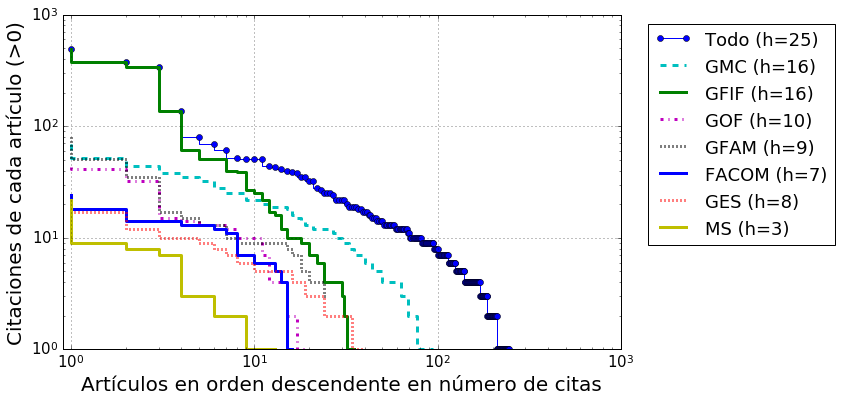

In [37]:
y=publicadas5.sort_values(by='Cites',ascending=False).reset_index(drop=True).Cites
x=np.asarray(y.index+1)
plt.step(x,y,'bo',lw=1,label='Todo (h=%d)' %h_index(x,y))
plt.xscale('log')
plt.yscale('log')


for G in ['GMC','GFIF','GOF','GFAM','FACOM','GES','MS']:
    y=publicadas5[publicadas5.Grupo.str.contains(G)].sort_values(by='Cites',\
                            ascending=False).reset_index(drop=True).Cites
    x=np.asarray(y.index+1)

    plt.loglog(x,y,s[G],lw=3,drawstyle='steps',label='%s (h=%d)' %(G,h_index(x,y)))
    
plt.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.xlim(1-0.1)
plt.xlabel(u'Artículos en orden descendente en número de citas',size=20)
plt.ylabel(u'Citaciones de cada artículo (>0)',size=20)
plt.grid()

GFIF: 5 artículos en CMS que en realidad son 10 (h-> 21)

In [38]:
publicadas5[publicadas5.First_UdeA_Author.str.contains('José David Ruíz')][['Title','Cites','First_UdeA_Author']].shape

(5, 3)

#### Indidual histórico
Sólo publicaciones UdeA

In [39]:
ah=pd.DataFrame()
for a in publifull.UdeA_Author.unique():
    y=publifull[publifull.UdeA_Author==a].sort_values(by='Cites',ascending=False).reset_index(drop=True).Cites
    x=np.asarray(y.index+1)
    h=h_index(x,y)
    ah=ah.append({'Author':a,'Cites':y.sum(),'h-index':h},ignore_index=True)

ah[ah['h-index']>0].sort_values(by=['h-index','Cites'],ascending=False).reset_index(drop=True)

,Author,Cites,h-index
0,Carlos Duque Echeverri,2513,25
1,Ponce Gutiérrez William Alberto,1242,17
2,Barrero Meneses César A.,927,17
3,Morales Aramburo Álvaro,1023,16
4,Restrepo Quintero Diego Alejandro,672,16
5,Restrepo Cárdenas Johans,600,16
6,Barrera Ramírez John Fredy,677,15
7,Nardi Enrico,1723,14
8,Reyes Gómez Ernesto Amador,432,14
9,Henao Henao Rodrigo,513,11


#### Individual últimos cinco años
Sólo publicaciones UdeA

In [40]:
ah=pd.DataFrame()
for a in publifull5.UdeA_Author.unique():
    y=publifull5[publifull5.UdeA_Author==a].sort_values(by='Cites',ascending=False).reset_index(drop=True).Cites
    x=np.asarray(y.index+1)
    h=h_index(x,y)
    ah=ah.append({'Author':a,'Cites':y.sum(),'h-index':h},ignore_index=True)

ah[ah['h-index']>0].sort_values(by=['h-index','Cites'],ascending=False).reset_index(drop=True)

,Author,Cites,h-index
0,Carlos Duque Echeverri,896,16
1,Barrera Ramírez John Fredy,211,10
2,Pachón Contreras Leonardo,187,9
3,Restrepo Quintero Diego Alejandro,174,9
4,Romano Antonio Enea,163,7
5,Rueda Muñoz Edgar Alberto,80,7
6,Zapata Noreña Oscar,118,6
7,Zuluaga Callejas Jorge Iván,79,6
8,José David Ruíz Álvarez,1368,5
9,Sanz Vicario José Luis,120,5


### Conclusión:
Sabemos hacer el menú del día, pero...

_¿Como hacer un plato gourmet?_

## Resultados sobre índicadores asociados a las revistas

### Clasificación Colciencias

In [41]:
total=publicadas['Clasificación Colciencias'].value_counts()
print "Total A1+A2: ",total['A1']+total['A2']

Total A1+A2:  717


#### Histórico

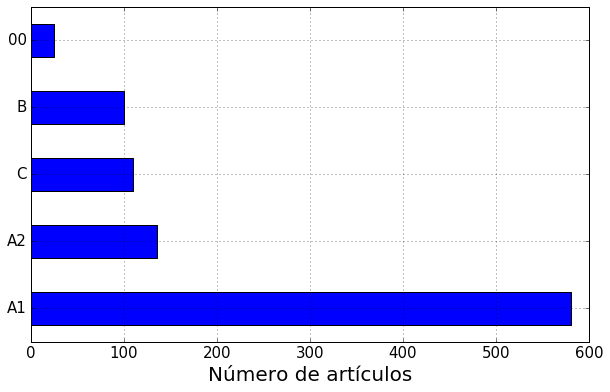

In [42]:
publicadas['Clasificación Colciencias'].value_counts().plot(kind='barh',grid=True)
plt.xlabel(u'Número de artículos',size=20)

#### Últimos cinco  años

In [43]:
total=publicadas5['Clasificación Colciencias'].value_counts()
print "Total A1+A2: ",total['A1']+total['A2']

Total A1+A2:  299


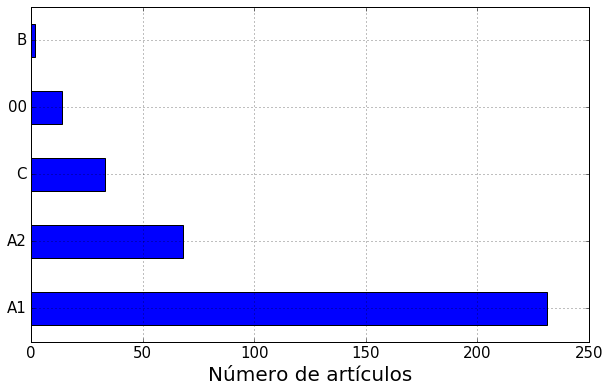

In [44]:
publicadas5['Clasificación Colciencias'].value_counts().plot(kind='barh',grid=True)
plt.xlabel(u'Número de artículos',size=20)

#### Publicadas último año

In [45]:
import datetime
publicadas1=publicadas[publicadas['Año']>datetime.datetime.now().year-1]
len(publicadas1)

6

<h2 id="FI">Factor de impacto</h2>
### Factor de impacto (FI) en revistas con FI>0
Factor de impacto de los últimos 4 años. Para publicaciones muy antigüas se usa el FI más antigüo

#### Histórico

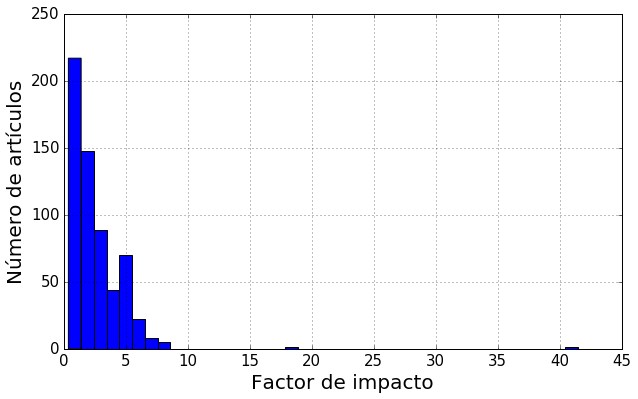

In [46]:
fi=publicadas[['Factor de Impacto']].replace('null',0)
fii=fi[fi['Factor de Impacto']>0].reset_index(drop=True)
fii.astype('float')['Factor de Impacto'].hist(bins=40)
plt.ylabel(u'Número de artículos',size=20)
plt.xlabel(u'Factor de impacto',size=20)

Impondremos un corte para facilitar la visualización: FI<15

In [47]:
publicadaslt15=publicadas[publicadas['Factor de Impacto']<15]

#### Histórico por Grupos

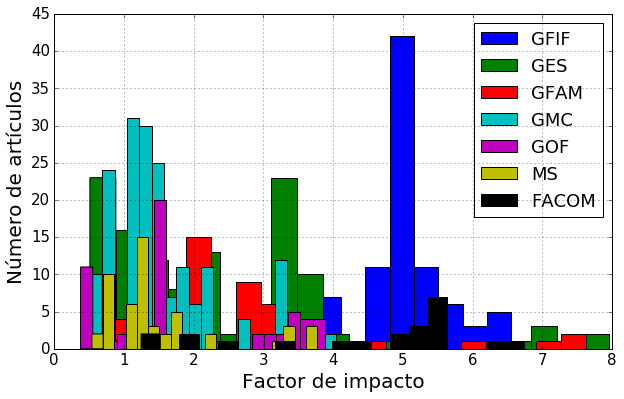

In [48]:
for group in ['GFIF','GES','GFAM','GMC','GOF','MS','FACOM']:
    fi=publicadaslt15[publicadaslt15['Grupo'].str.contains(group)][['Factor de Impacto']].replace('null',0)
    fii=fi[fi['Factor de Impacto']>0].reset_index(drop=True)
    fii.astype('float')['Factor de Impacto'].hist(bins=20,label=group) 
    plt.legend(loc='best')
    plt.ylabel(u'Número de artículos',size=20)
    plt.xlabel(u'Factor de impacto',size=20)

#### Últimos cinco años Global

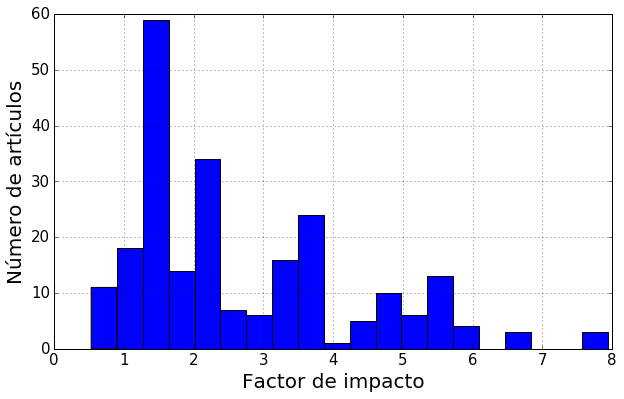

In [49]:
publicadas5['Factor de Impacto']=publicadas5['Factor de Impacto'].replace('Desconocido',-1)
fi=publicadas5[['Factor de Impacto']].replace('null',0)
fii=fi[fi['Factor de Impacto']>0].reset_index(drop=True)
fii.astype('float')['Factor de Impacto'].hist(bins=20)
plt.ylabel(u'Número de artículos',size=20)
plt.xlabel(u'Factor de impacto',size=20)

#### Últimos cinco años: por Grupos

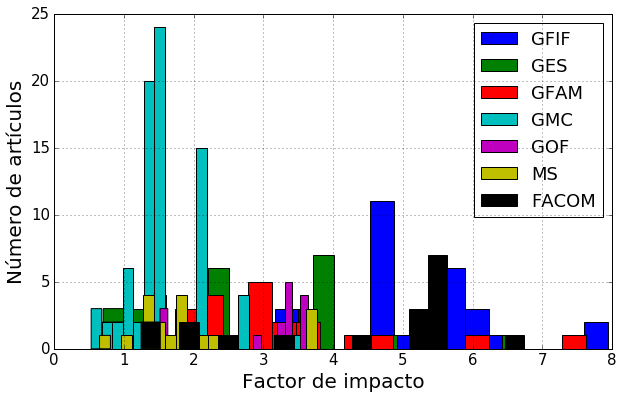

In [50]:
for group in ['GFIF','GES','GFAM','GMC','GOF','MS','FACOM']:
    fi=publicadas5[publicadas5['Grupo'].str.contains(group)][['Factor de Impacto']].replace('null',0)
    fii=fi[fi['Factor de Impacto']>0].reset_index(drop=True)
    fii.astype('float')['Factor de Impacto'].hist(bins=20,label=group) 
    plt.legend(loc='best')
    plt.ylabel(u'Número de artículos',size=20)
    plt.xlabel(u'Factor de impacto',size=20)

Detalles

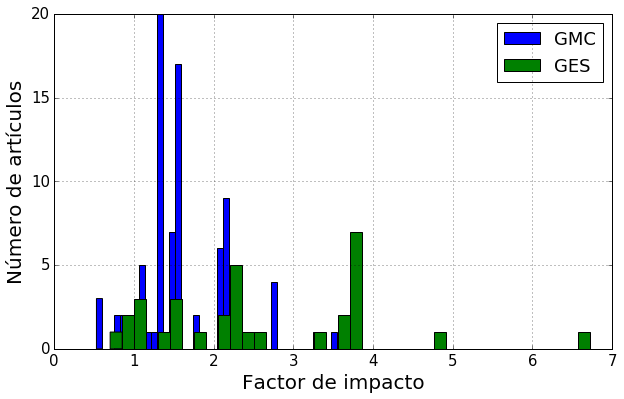

In [51]:
for group in ['GMC','GES']:
    fi=publicadas5[publicadas5['Grupo'].str.contains(group)][['Factor de Impacto']].replace('null',0)
    fii=fi[fi['Factor de Impacto']>0].reset_index(drop=True)
    fii.astype('float')['Factor de Impacto'].hist(bins=40,label=group) 
    plt.legend(loc='best')
    plt.ylabel(u'Número de artículos',size=20)
    plt.xlabel(u'Factor de impacto',size=20)

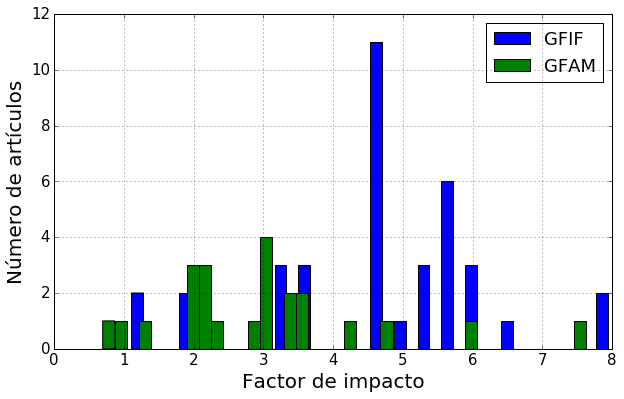

In [52]:
for group in ['GFIF','GFAM']:
    fi=publicadas5[publicadas5['Grupo'].str.contains(group)][['Factor de Impacto']].replace('null',0)
    fii=fi[fi['Factor de Impacto']>0].reset_index(drop=True)
    fii.astype('float')['Factor de Impacto'].hist(bins=40,label=group) 
    plt.legend(loc='best')
    plt.ylabel(u'Número de artículos',size=20)
    plt.xlabel(u'Factor de impacto',size=20)

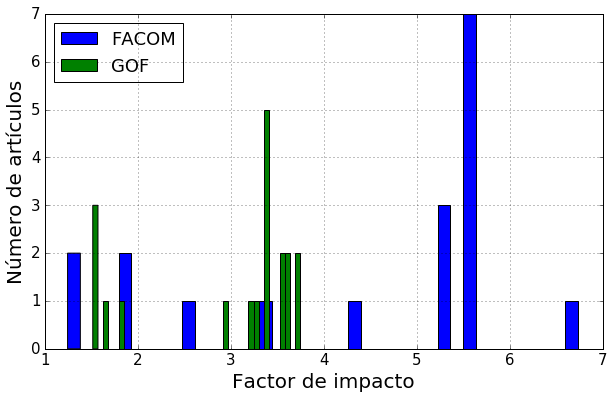

In [53]:
for group in ['FACOM','GOF']:
    fi=publicadas5[publicadas5['Grupo'].str.contains(group)][['Factor de Impacto']].replace('null',0)
    fii=fi[fi['Factor de Impacto']>0].reset_index(drop=True)
    fii.astype('float')['Factor de Impacto'].hist(bins=40,label=group) 
    plt.legend(loc='best')
    plt.ylabel(u'Número de artículos',size=20)
    plt.xlabel(u'Factor de impacto',size=20)

## Y patentes:
2

## Conclusiones generales

* Una estrategía mínima para mantener la media de publicaciones de los grupos es garantizar el relevo de sus miembros _activos_.

* El número promedio de artículos por año para un teórico _activo_ es de 4 artículos (en el caso conservador), y para un experimental _activo_ es de 1. 

* Los aproximadamente 5 artículos de CMS se notan en los gráficos de citaciones. CMS y ATLAS están produciendo ~100 artículos por año con ~10,000 citaciones. Ver pr ejemplo: 

   http://inspirehep.net/search?p=cn+atlas+and+date+2012&of=hcs

   Las grandes colaboraciones impactan fuertemente en cantidad y calidad de artículos. 

* En general: el incremento en el impacto de las publicaciones requiere cambios de paradigma.

* Congresos bien establecidos pueden crear incentivos de publicación en estudiantes

* El fortalecimiento del área de astrofísica se ha comenzado a notar en los últimos tres años, tanto en número como en el impacto de las publicaciones.

In [54]:
stop=time.time()
stop-start

26.16217803955078